<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/overview_Jan9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import os
import glob
import random
from PIL import Image
from torch.utils.data import Dataset,random_split
from datasets import Dataset, DatasetDict
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
model_name="caltech256-xlstm"

from google.colab import drive
drive.mount('/content/drive')

import os

CHECKPOINTS_DIR = '/content/drive/MyDrive/ckpts'

def save_checkpoint(model, optimizer, epoch):
    os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
    checkpoint_path = f'{CHECKPOINTS_DIR}/{model_name}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f"ckpt saved for {model_name} at epoch {epoch}.")

def load_checkpoint(model, optimizer):
    ckpt_path = f'{CHECKPOINTS_DIR}/{model_name}.pth'
    if not os.path.exists(ckpt_path):
        print(f"no ckpt found for {model_name} starting from epoch 0.")
        return 0

    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"ckpt loaded for {model_name} from {ckpt_path}. resuming from epoch {start_epoch}.")

    return start_epoch

Mounted at /content/drive


In [4]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("jessicali9530/caltech256")
print("Path to dataset files:", path)

100%|██████████| 2.12G/2.12G [01:51<00:00, 20.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/caltech256/versions/2


In [5]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import glob
from torchvision import transforms

def set_style():
    """Set the style for prettier visualizations"""
    plt.style.use('default')  # Using default style instead of seaborn
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['figure.dpi'] = 150

def create_random_mask(size, mask_ratio=0.05):  # Reduced mask ratio to 5%
    """
    Create multiple small random masks
    """
    height, width = size
    mask = np.ones((height, width), np.float32)

    # Create 2-4 small masks instead of one large mask
    num_masks = random.randint(2, 4)

    for _ in range(num_masks):
        # Calculate small rectangle dimensions
        mask_height = int(height * np.sqrt(mask_ratio))
        mask_width = int(width * np.sqrt(mask_ratio))

        # Make masks even smaller with random scaling
        scale = random.uniform(0.3, 0.7)
        mask_height = int(mask_height * scale)
        mask_width = int(mask_width * scale)

        # Calculate random position
        top = random.randint(0, height - mask_height)
        left = random.randint(0, width - mask_width)

        # Apply mask
        mask[top:top + mask_height, left:left + mask_width] = 0

    return mask

def process_and_visualize_masked_images(data_path, num_samples=5, target_size=(256, 256)):
    """
    Process images with masks and visualize results with enhanced styling
    """
    # Set the style
    set_style()

    # Get image paths
    image_paths = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))

    # Select random images
    selected_images = random.sample(image_paths, min(num_samples, len(image_paths)))

    # Setup transforms
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
    ])

    # Create figure with better spacing
    fig = plt.figure(figsize=(20, 4))
    plt.subplots_adjust(wspace=0.3)

    for idx, img_path in enumerate(selected_images):
        # Load and transform image
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img)

        # Create mask
        mask = create_random_mask(target_size)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)

        # Apply mask to image
        masked_img = img_tensor * mask_tensor

        # Convert tensors back to numpy for visualization
        orig_img = img_tensor.permute(1, 2, 0).numpy()
        mask_viz = mask_tensor.permute(1, 2, 0).numpy()
        masked_img = masked_img.permute(1, 2, 0).numpy()

        # Create subplots in a vertical arrangement
        ax1 = plt.subplot(3, num_samples, idx + 1)
        ax2 = plt.subplot(3, num_samples, idx + 1 + num_samples)
        ax3 = plt.subplot(3, num_samples, idx + 1 + 2*num_samples)

        # Plot with enhanced styling
        ax1.imshow(orig_img)
        ax1.set_title('Original', pad=5)

        ax2.imshow(mask_viz, cmap='cool')  # Changed mask colormap
        ax2.set_title('Mask', pad=5)

        ax3.imshow(masked_img)
        ax3.set_title('Masked', pad=5)

        # Remove axes for cleaner look
        for ax in [ax1, ax2, ax3]:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)

    plt.tight_layout()
    plt.show()

def create_masked_dataset(data_path, num_images=1000, target_size=(256, 256)):
    """
    Create a dataset of original and masked images
    """
    # Get all image paths
    image_paths = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))

    # Select random images
    selected_images = random.sample(image_paths, min(num_images, len(image_paths)))

    # Setup transforms
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
    ])

    dataset = []
    for img_path in selected_images:
        # Load and transform image
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img)

        # Create mask
        mask = create_random_mask(target_size)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)

        # Apply mask to image
        masked_img = img_tensor * mask_tensor

        dataset.append({
            'original': img_tensor,
            'masked': masked_img,
            'mask': mask_tensor
        })

    return dataset

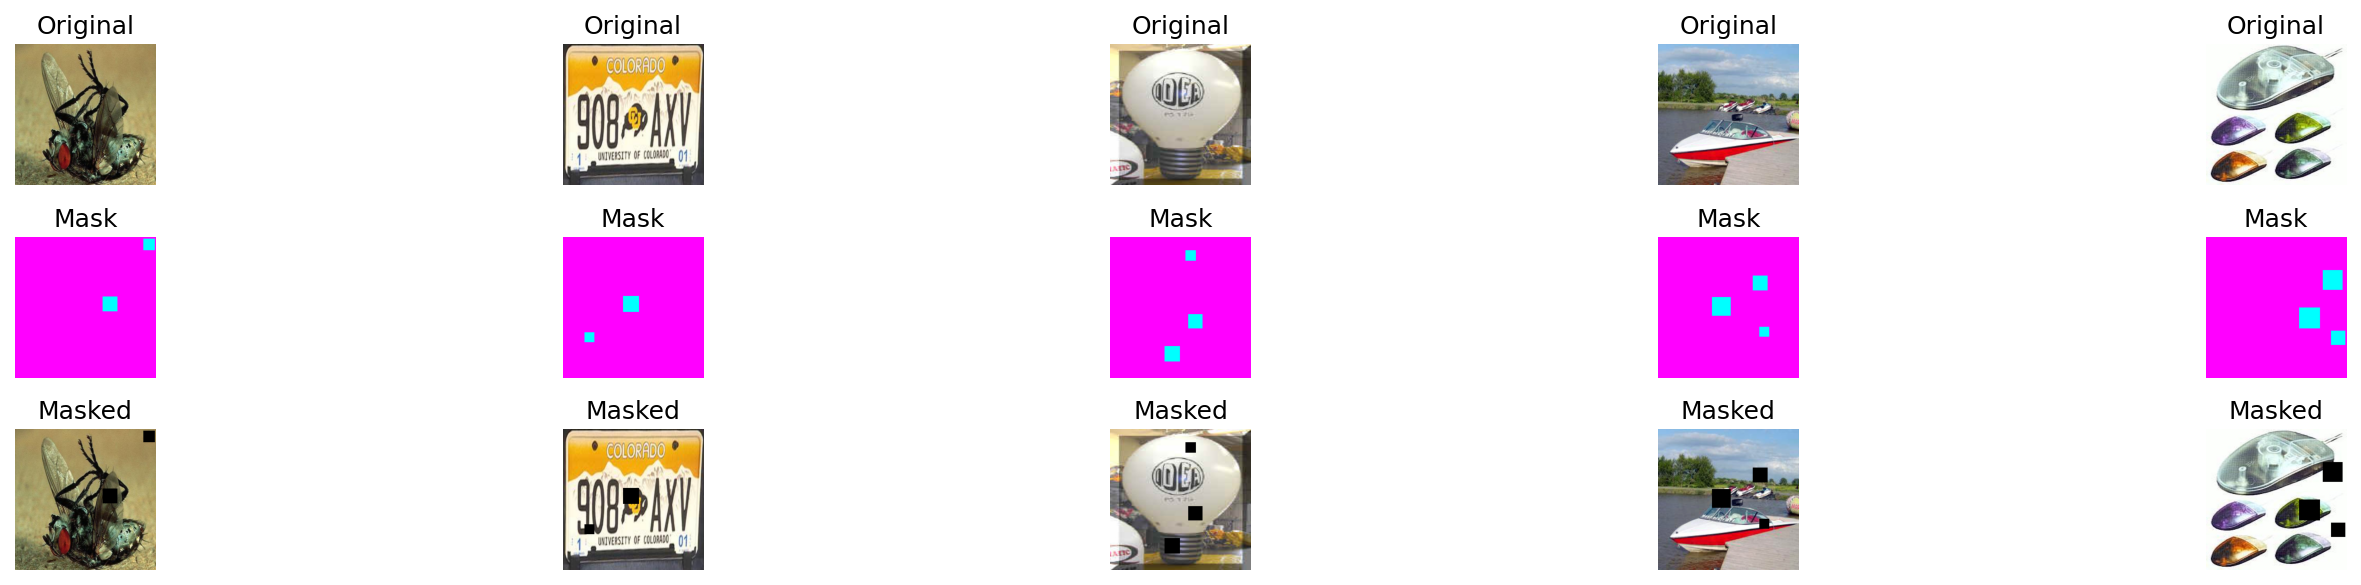

In [6]:
# Visualize 5 random images with their new masks
process_and_visualize_masked_images(path, num_samples=5)

In [7]:
import torch
import torch.nn as nn
import math

class SpatialEncoding(nn.Module):
    def __init__(self, d_model, patch_size, max_h=32, max_w=32):
        super().__init__()
        self.d_model = d_model
        self.patch_size = patch_size

        # Create position encoding matrices
        pe_h = torch.zeros(max_h, d_model // 2)
        pe_w = torch.zeros(max_w, d_model // 2)

        # Calculate position encodings
        div_term = torch.exp(torch.arange(0, d_model // 2, 2) * (-math.log(10000.0) / d_model))

        for pos_h in range(max_h):
            pe_h[pos_h, 0::2] = torch.sin(pos_h * div_term)
            pe_h[pos_h, 1::2] = torch.cos(pos_h * div_term)

        for pos_w in range(max_w):
            pe_w[pos_w, 0::2] = torch.sin(pos_w * div_term)
            pe_w[pos_w, 1::2] = torch.cos(pos_w * div_term)

        self.register_buffer('pe_h', pe_h)
        self.register_buffer('pe_w', pe_w)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, seq_len, embedding_dim)
        Returns: Tensor of same shape with added spatial encodings
        """
        batch_size, seq_len, _ = x.shape
        h = w = int(math.sqrt(seq_len))  # Assuming square patches

        # Get spatial positions for each patch
        positions_h = torch.arange(h).repeat_interleave(w)
        positions_w = torch.arange(w).repeat(h)

        # Get encodings for each position
        encoding_h = self.pe_h[positions_h]
        encoding_w = self.pe_w[positions_w]

        # Combine horizontal and vertical encodings
        spatial_encoding = torch.cat([encoding_h, encoding_w], dim=-1)

        # Add spatial encodings to input
        return x + spatial_encoding.unsqueeze(0).repeat(batch_size, 1, 1)

class XLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, patch_size, num_layers=2):
        super().__init__()
        self.patch_size = patch_size
        self.hidden_size = hidden_size

        # Image to patches embedding
        self.patch_embedding = nn.Sequential(
            nn.Linear(patch_size * patch_size * 3, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU()
        )

        # Spatial encoding
        self.spatial_encoding = SpatialEncoding(hidden_size, patch_size)

        # Bidirectional LSTM layers
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True
        )

        # Output projection
        self.output = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, patch_size * patch_size * 3)
        )

    def forward(self, x, mask):
        """
        x: Input image tensor (B, C, H, W)
        mask: Binary mask tensor (B, 1, H, W)
        Returns: Reconstructed image tensor (B, C, H, W)
        """
        B, C, H, W = x.shape
        P = self.patch_size

        # Convert image to patches
        patches = x.unfold(2, P, P).unfold(3, P, P)
        patches = patches.contiguous().view(B, -1, C * P * P)

        # Create patch embeddings
        embedded = self.patch_embedding(patches)

        # Add spatial encoding
        embedded = self.spatial_encoding(embedded)

        # Process through LSTM
        lstm_out, _ = self.lstm(embedded)

        # Generate output patches
        output_patches = self.output(lstm_out)

        # Reshape back to image
        h_patches = H // P
        w_patches = W // P
        output = output_patches.view(B, h_patches, w_patches, C, P, P)
        output = output.permute(0, 3, 1, 4, 2, 5).contiguous()
        output = output.view(B, C, H, W)

        # Combine with original image using mask
        return x * mask + output * (1 - mask)

# Training configuration
class Config:
    batch_size = 32
    learning_rate = 1e-4
    num_epochs = 100
    patch_size = 16
    hidden_size = 256
    save_interval = 10

def train_model(model, train_dataset, config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = nn.MSELoss()

    # Load checkpoint if exists
    start_epoch = load_checkpoint(model, optimizer)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True
    )

    for epoch in range(start_epoch, config.num_epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            original = batch['original'].to(device)
            masked = batch['masked'].to(device)
            mask = batch['mask'].to(device)

            optimizer.zero_grad()
            output = model(masked, mask)
            loss = criterion(output, original)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{config.num_epochs}, Loss: {avg_loss:.4f}')

        if (epoch + 1) % config.save_interval == 0:
            save_checkpoint(model, optimizer, epoch)

In [8]:
# Initialize model and configuration
config = Config()
model = XLSTM(
    input_size=config.patch_size * config.patch_size * 3,
    hidden_size=config.hidden_size,
    patch_size=config.patch_size
)

# Create dataset
dataset = create_masked_dataset(path, num_images=1000)

# Train model
train_model(model, dataset, config)

<ipython-input-3-22edd605f4af>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


ckpt loaded for caltech256-xlstm from /content/drive/MyDrive/ckpts/caltech256-xlstm.pth. resuming from epoch 100.


In [11]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 41.5 MB/s eta 0:00:00


<ipython-input-3-22edd605f4af>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)
/usr/local/lib/python3.10/dist-packages/torchmetrics/util

ckpt loaded for caltech256-xlstm from /content/drive/MyDrive/ckpts/caltech256-xlstm.pth. resuming from epoch 100.
Average PSNR: 27.48
Average SSIM: 0.97


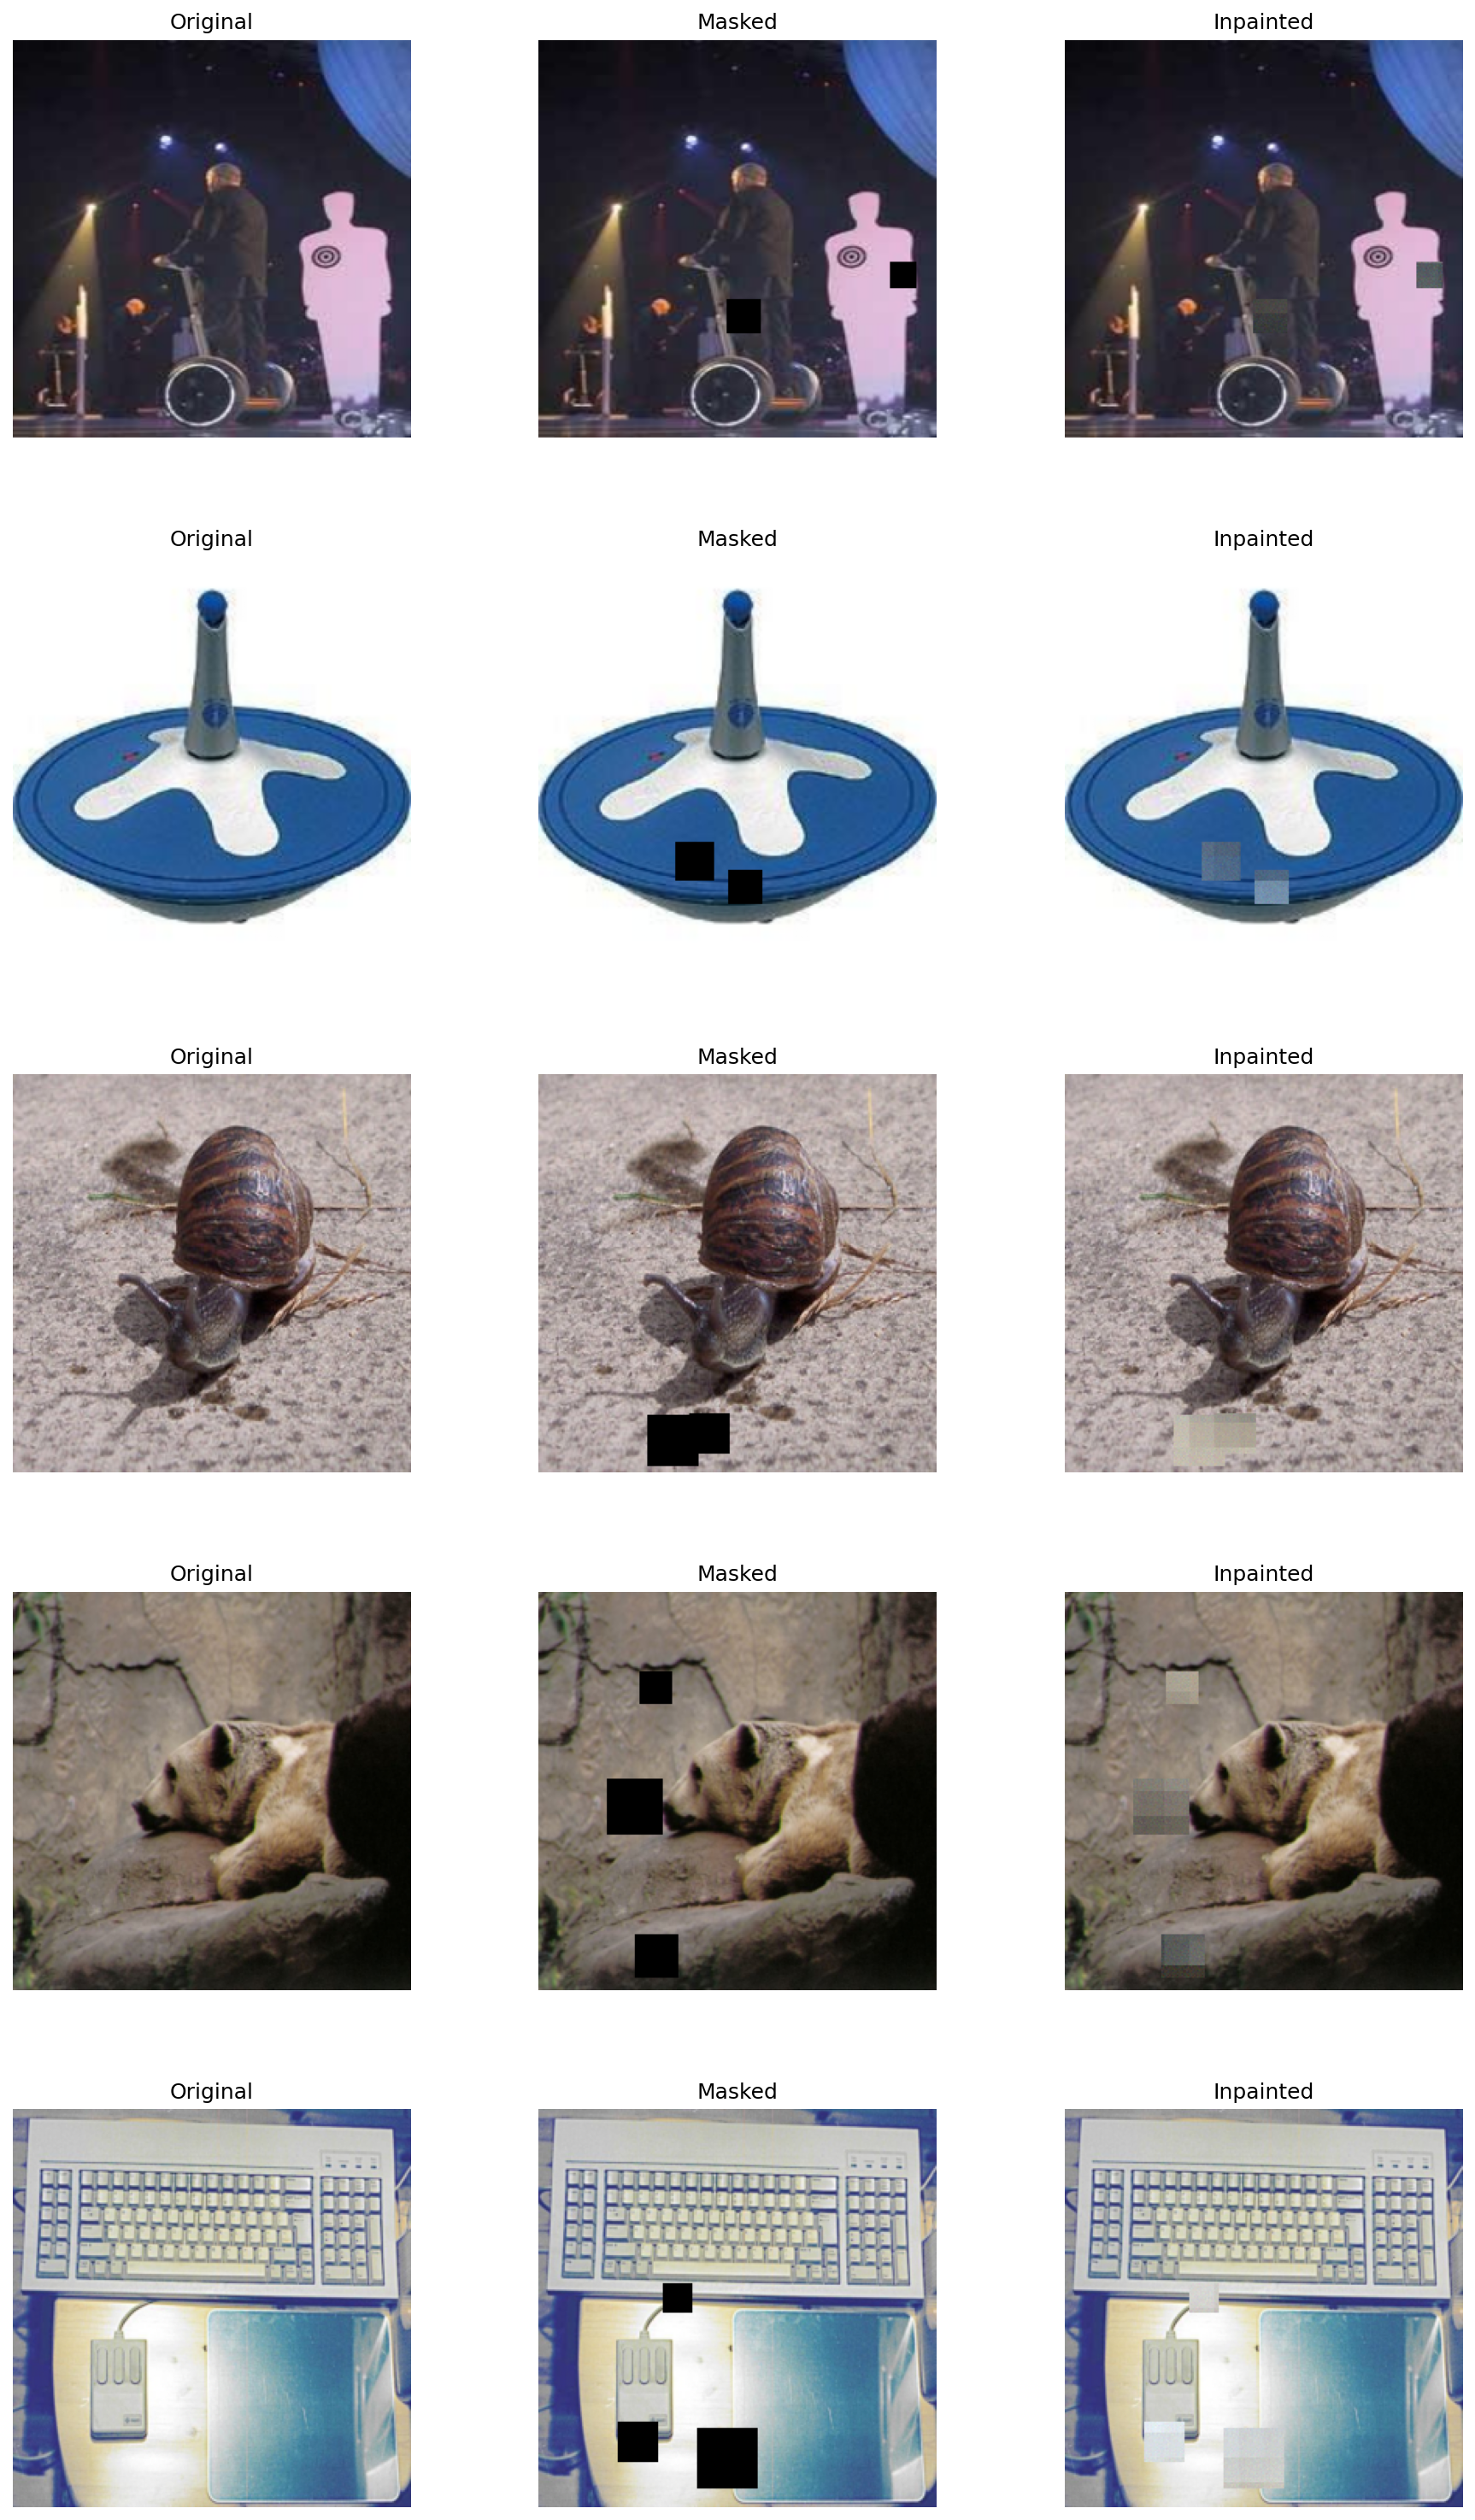

IsADirectoryError: [Errno 21] Is a directory: '/root/.cache/kagglehub/datasets/jessicali9530/caltech256/versions/2/256_ObjectCategories/105.horse'

In [12]:
import torch
import torch.nn as nn
import torchvision.utils as vutils
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple

class ModelEvaluator:
    def __init__(self, model: nn.Module, device: torch.device):
        self.model = model
        self.device = device
        self.psnr = PeakSignalNoiseRatio().to(device)
        self.ssim = StructuralSimilarityIndexMeasure().to(device)

    @torch.no_grad()
    def evaluate_metrics(self, dataloader) -> Tuple[float, float]:
        """
        Evaluate model using PSNR and SSIM metrics
        """
        self.model.eval()
        total_psnr = 0
        total_ssim = 0
        num_samples = 0

        for batch in dataloader:
            original = batch['original'].to(self.device)
            masked = batch['masked'].to(self.device)
            mask = batch['mask'].to(self.device)

            output = self.model(masked, mask)

            # Calculate metrics
            psnr_val = self.psnr(output, original)
            ssim_val = self.ssim(output, original)

            total_psnr += psnr_val.item()
            total_ssim += ssim_val.item()
            num_samples += 1

        avg_psnr = total_psnr / num_samples
        avg_ssim = total_ssim / num_samples

        return avg_psnr, avg_ssim

    def visualize_results(self,
                         dataloader,
                         num_samples: int = 5,
                         save_path: str = None) -> None:
        """
        Visualize original, masked, and inpainted images
        """
        self.model.eval()

        # Get random batch
        batch = next(iter(dataloader))
        original = batch['original'].to(self.device)[:num_samples]
        masked = batch['masked'].to(self.device)[:num_samples]
        mask = batch['mask'].to(self.device)[:num_samples]

        # Generate inpainted images
        with torch.no_grad():
            output = self.model(masked, mask)

        # Create figure
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
        plt.subplots_adjust(hspace=0.3)

        # Helper function to convert tensor to numpy image
        def to_numpy_image(tensor):
            return tensor.cpu().permute(1, 2, 0).numpy().clip(0, 1)

        for idx in range(num_samples):
            # Original image
            axes[idx, 0].imshow(to_numpy_image(original[idx]))
            axes[idx, 0].set_title('Original')

            # Masked image
            axes[idx, 1].imshow(to_numpy_image(masked[idx]))
            axes[idx, 1].set_title('Masked')

            # Inpainted result
            axes[idx, 2].imshow(to_numpy_image(output[idx]))
            axes[idx, 2].set_title('Inpainted')

            # Remove axes
            for ax in axes[idx]:
                ax.axis('off')

        if save_path:
            plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.show()

    def evaluate_single_image(self,
                            image_path: str,
                            transform,
                            save_path: str = None) -> Tuple[float, float]:
        """
        Evaluate model on a single image
        """
        # Load and transform image
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(self.device)

        # Create mask
        mask = create_random_mask(img_tensor.shape[2:])
        mask_tensor = torch.from_numpy(mask).unsqueeze(0).unsqueeze(0).to(self.device)

        # Create masked image
        masked_img = img_tensor * mask_tensor

        # Generate inpainting
        self.model.eval()
        with torch.no_grad():
            output = self.model(masked_img, mask_tensor)

        # Calculate metrics
        psnr_val = self.psnr(output, img_tensor).item()
        ssim_val = self.ssim(output, img_tensor).item()

        # Visualize
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(img_tensor[0].cpu().permute(1, 2, 0).numpy())
        axes[0].set_title(f'Original')

        axes[1].imshow(masked_img[0].cpu().permute(1, 2, 0).numpy())
        axes[1].set_title(f'Masked')

        axes[2].imshow(output[0].cpu().permute(1, 2, 0).numpy())
        axes[2].set_title(f'Inpainted\nPSNR: {psnr_val:.2f}, SSIM: {ssim_val:.2f}')

        for ax in axes:
            ax.axis('off')

        if save_path:
            plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.show()

        return psnr_val, ssim_val

def create_evaluation_dataset(data_path: str, num_images: int = 100):
    """
    Create a separate evaluation dataset
    """
    dataset = create_masked_dataset(data_path, num_images)
    eval_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=16,
        shuffle=False
    )
    return eval_loader

# Example usage
def evaluate_model():
    # Initialize model and load checkpoint
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    config = Config()

    model = XLSTM(
        input_size=config.patch_size * config.patch_size * 3,
        hidden_size=config.hidden_size,
        patch_size=config.patch_size
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    load_checkpoint(model, optimizer)

    # Create evaluator
    evaluator = ModelEvaluator(model, device)

    # Create evaluation dataset
    eval_loader = create_evaluation_dataset(path)

    # Calculate metrics
    psnr, ssim = evaluator.evaluate_metrics(eval_loader)
    print(f'Average PSNR: {psnr:.2f}')
    print(f'Average SSIM: {ssim:.2f}')

    # Visualize results
    evaluator.visualize_results(
        eval_loader,
        num_samples=5,
        save_path='inpainting_results.png'
    )

    # Test on a single image
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    sample_image_path = glob.glob(os.path.join(path, '*/*.*'))[0]
    evaluator.evaluate_single_image(
        sample_image_path,
        transform,
        save_path='single_result.png'
    )

if __name__ == "__main__":
    evaluate_model()

In [ ]:
# Run full evaluation
evaluate_model()

# Or use individual components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = XLSTM(...).to(device)
evaluator = ModelEvaluator(model, device)

# Evaluate single image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
evaluator.evaluate_single_image('path/to/image.jpg', transform)